In [119]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  Normalizer , scale, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, mean_squared_error
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas import get_dummies
import xgboost as xgb
import scipy
import math
import json
import sys
import csv
import os
import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from tqdm import tqdm_notebook

In [120]:
dataset = pd.read_csv("historic_data/csv/TCS.NS.csv")

# Drop all rows where volume is 0
dataset = dataset[dataset["Volume"] != 0]

dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d-%m-%Y')
dataset['Date'] = dataset['Date'].dt.strftime('%Y-%m-%d')
dataset

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,2002-08-12,38.724998,38.724998,212976.0,40.000000,39.700001,28.484991
1,2002-08-13,38.875000,39.750000,153576.0,40.387501,39.162498,28.099335
2,2002-08-14,35.724998,39.250000,822776.0,39.250000,36.462502,26.162071
4,2002-08-16,35.750000,36.275002,811856.0,38.000000,36.375000,26.099281
5,2002-08-19,35.137501,36.674999,205880.0,36.674999,35.474998,25.453533
...,...,...,...,...,...,...,...
5149,2023-04-24,3126.149902,3151.100098,1640676.0,3180.949951,3174.800049,3174.800049
5150,2023-04-25,3147.500000,3183.000000,2024090.0,3191.199951,3176.000000,3176.000000
5151,2023-04-26,3181.000000,3181.000000,2000029.0,3208.399902,3198.149902,3198.149902
5152,2023-04-27,3170.649902,3185.000000,2434446.0,3199.199951,3187.949951,3187.949951


In [121]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('TCS Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('TCS Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [122]:
dataset['Open'].fillna((dataset['Open'].mean()), inplace=True)
dataset['Low'].fillna((dataset['Low'].mean()), inplace=True)

In [123]:
training_set = dataset[dataset['Date'] < '2018'].iloc[:,1:2].values
test_set = dataset[dataset['Date'] >= '2018'].iloc[:,1:2].values


In [124]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [125]:
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [126]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [127]:
X_train.shape

(2709, 60, 1)

In [102]:
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 16s 371ms/step - loss: 0.0795
Epoch 2/50
19/19 [==============================] - 7s 350ms/step - loss: 0.0458
Epoch 3/50
19/19 [==============================] - 6s 335ms/step - loss: 0.0258
Epoch 4/50
19/19 [==============================] - 6s 311ms/step - loss: 0.0079
Epoch 5/50
19/19 [==============================] - 6s 302ms/step - loss: 0.0039
Epoch 6/50
19/19 [==============================] - 6s 317ms/step - loss: 0.0031
Epoch 7/50
19/19 [==============================] - 6s 304ms/step - loss: 0.0029
Epoch 8/50
19/19 [==============================] - 6s 300ms/step - loss: 0.0029
Epoch 9/50
19/19 [==============================] - 6s 315ms/step - loss: 0.0027
Epoch 10/50
19/19 [==============================] - 7s 349ms/step - loss: 0.0026
Epoch 11/50
19/19 [==============================] - 6s 332ms/step - loss: 0.0028
Epoch 12/50
19/19 [==============================] - 6s 307ms/step - loss: 0.0024
Epoch 13/50
19/19 [=====

In [103]:
# Convert the Date column to a pandas datetime object
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Set the Date column as the index
dataset.set_index('Date', inplace=True)

# Concatenate the two subsets of the High column
dataset_total = pd.concat((dataset["High"][:'2016-12-31'],dataset["High"]['2017':]),axis=0)


In [104]:
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values

In [105]:
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [111]:
X_test = []
for i in range(60,1340):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

40/40 [==============================] - 1s 27ms/step


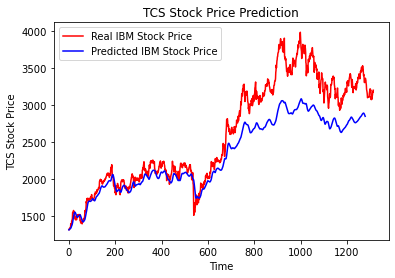

In [112]:
plot_predictions(test_set,GRU_predicted_stock_price)

In [113]:
return_rmse(test_set[:400], GRU_predicted_stock_price[:400])


The root mean squared error is 86.51166795908492.


In [130]:
for i in range(2):
    next_day_pred = regressorGRU.predict(last_60_days.reshape(1, -1, 2))
    next_two_days.append(next_day_pred[0, 0])
    last_60_days = np.append(last_60_days[1:], [[next_day_pred[0, 0], next_day_pred[0, 0]]], axis=0)


InvalidArgumentError: Graph execution error:

Specified a list with shape [?,1] from a tensor with shape [1,2]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[sequential_5/gru_16/PartitionedCall]] [Op:__inference_predict_function_88693]